#### Revision Notes (2017-01-21)
This is my second submission. According to grader's feedback on my first submission, I made following revisions:
- Added 'Part 1: Key Questions and Assumptions' to list questions and assumptions I had before I start this data exploration.
- Added 'Part 4: Summary of Key Findings' to summarize key findings and identify potential directions for future analysis.
- Updated all charts: Added titles and labels for better communication. 
- About data wrangling: I planned to conduct data cleaning before formal analysis, but this database already seems very tidy, there is not much left for me to wrangle. I converted data type at the beginning of Part 1; took care of missing values of appearance data in part 3.3; merged different tables and only kept relevant columns in my dataframes (but I didn't export them to csv files, since it is easy to reproduce them from raw data). I hope these actions are sufficient to meet the requirement of this project.

## Foreword
- There are two database available for this project assignment: Titanic passager database and baseball database. I chose baseball database instead of Titanic database because I already read a lot of Titanic database analysis articles on Kaggle before. I want to try a whole new database by myself for this project.
- However, I know very little about the rules of baseball, so I avoided detail technical variables(pitching/fielding and etc.) in this analysis and focused on non-technical variables (such as # of games won, award earned, total years played, birth year, height/weight and etc.)
- Full database can be found in the folder 'baseballdatabank-master_2016-03-02'. In this analysis, I only utilized four of those csv files:
    - Master.csv
    - Salaries.csv
    - AwardsPlayers.csv
    - Appearances.csv

## Index
#### Part 1: Key Questions and Assumptions

#### Part 2: Descriptive Statistics on Players' Bio
- Debut Age
- Career Length
- Birth Country
- Left/right Hand

#### Part 3: Salary Analysis
- Salary vs League
- Salary vs Player's Experience
- Salary vs Player's Appearances

#### Part 4: Summary of Key Findings

#### Part 5: Limitations of This Analysis

---

## Part 1: Key Questions and Assumptions

I am interested in following aspects of this baseball database:
- Player Biography related questions:
    - Professional baseball players usually start their career at what age?
    - How long would they play for the leagues?
    - AL and NL are both leagues in America. In this 'melting-pot' country with a lot of immigrants, how many baseball players are immigrants?
    - Is left-handed a common phenomenon among baseball players?
- What variables are correlated with player's annual salary level?
    - Do AL and NL have different salary patterns?
    - Any difference in salary pattern among different roles in the games?
    - I assume players who are **more experienced** or **earned more awards** or **show up in the games more frequently** tend to earn higher salary. Is this assumption true?

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
%matplotlib inline

In [2]:
#Create function for quick access to file path
def csv_path(filename):
    return 'baseballdatabank-master_2016-03-02/baseballdatabank-master/core/'+filename

## Part 2: Descriptive Statistics on Players' Bio

In [3]:
# Import master sheet and focus on players who was born after 1979
master=pd.read_csv(csv_path('Master.csv'))
master_selected=master.copy()[master['birthYear']>=1980]
print(len(master_selected))
master_selected.head()

2454


,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,220.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
5,abadfe01,1985.0,12.0,17.0,D.R.,La Romana,La Romana,NaN,NaN,NaN,...,Abad,Fernando Antonio,220.0,73.0,L,L,2010-07-28,2015-10-03,abadf001,abadfe01
21,abercre01,1980.0,7.0,15.0,USA,GA,Columbus,NaN,NaN,NaN,...,Abercrombie,Reginald Damascus,215.0,75.0,R,R,2006-04-04,2008-09-28,aberr001,abercre01
35,abreujo02,1987.0,1.0,29.0,Cuba,Cienfuegos,Cienfuegos,NaN,NaN,NaN,...,Abreu,Jose Dariel,255.0,75.0,R,R,2014-03-31,2015-10-03,abrej003,abreujo02
36,abreuju01,1985.0,4.0,8.0,D.R.,Duarte,San Francisco de Macoris,NaN,NaN,NaN,...,Abreu,Juan de Dios,185.0,72.0,R,R,2011-08-29,2011-09-27,abrej002,abreuju01


In [4]:
#Exclude players with debut date missing (only one player missed this value)
master_selected=master_selected[master_selected['debut'].apply(type)==str]
len(master_selected)

2453

In [5]:
#Extract debut year from debut 
def get_year(str_date):
    return int(str_date[:4])

master_selected['debut_year']=master_selected['debut'].apply(get_year)

In [6]:
#Convert string type date to datetime for calculation
#Missing finalGame date means the player is still active, so fill it as '2016-01-01' for the convenience of later calculation 
def convert_date(date):
    if type(date)==str:
        return dt.strptime(date,'%Y-%m-%d')
    else:
        return dt.strptime('2016-01-01','%Y-%m-%d')
    
master_selected['finalGame']=master_selected['finalGame'].apply(convert_date)
master_selected['debut']=master_selected['debut'].apply(convert_date)

In [7]:
#Calculate each player's total years by subtracting debut date from finalGame date, present as 2-decimal float
def year_convert(timedelta_data):
    return round(timedelta_data.days/365,2)

master_selected['yearsPlayed']=master_selected['finalGame']-master_selected['debut']
master_selected['yearsPlayed']=master_selected['yearsPlayed'].apply(year_convert)

In [8]:
#Calculate player's age when baseball career started
master_selected['ageDebut']=master_selected['debut_year']-master_selected['birthYear']

### 2.1 Debut Age:
Selected players started their career around 23-26 years old. While young players can enter the league at the age of 19, a debut age of 33 is also possible.  

In [9]:
master_selected['ageDebut'].describe()

count    2453.000000
mean       24.432124
std         1.980734
min        19.000000
25%        23.000000
50%        24.000000
75%        26.000000
max        33.000000
Name: ageDebut, dtype: float64

### 2.2 Career Length:
I don't watch baseball, so this statistics is a little bit surprising for me, since the career length is much shorter than I thought. On average, players only play in professional leagues for ~3 years and 75% of them play for less than 5.14 years.

In [10]:
master_selected['yearsPlayed'].describe()

count    2453.000000
mean        3.338630
std         3.079433
min         0.000000
25%         0.880000
50%         2.380000
75%         5.140000
max        14.520000
Name: yearsPlayed, dtype: float64

A potential anomaly within data is that the minimum years is 0.0, so I will take a closer look on them. Seems like many players only show up in the league game once. I don't have good reasons to exclude them, so let's keep them in the record for now.

In [11]:
anomaly=master_selected[master_selected['yearsPlayed']==0.0][['debut','finalGame']]
print(len(anomaly))
anomaly.head()

36


,debut,finalGame
715,2013-06-08,2013-06-08
991,2015-05-28,2015-05-28
1053,2013-09-27,2013-09-27
2064,2012-10-03,2012-10-03
2103,2014-06-20,2014-06-20


### 2.3 Birth Country:
28% of selected players were born outside USA

About 28.05% of professional players are immigrants


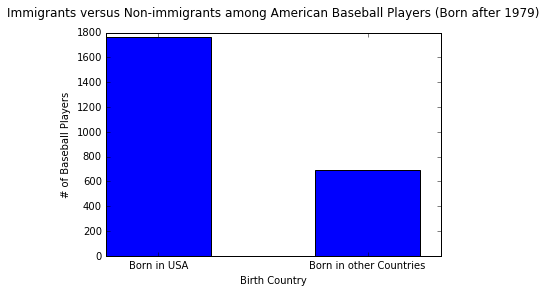

In [12]:
print('About {}% of professional players are immigrants'.format(round(100*sum(master_selected['birthCountry']!='USA')/len(master_selected),2)))
plt.bar([0,1],[sum(master_selected['birthCountry']=='USA'),sum(master_selected['birthCountry']!='USA')],0.5,color='b')
plt.xticks([0.25,1.25],['Born in USA', 'Born in other Countries'])
plt.xlabel('Birth Country')
plt.ylabel('# of Baseball Players')
plt.title('Immigrants versus Non-immigrants among American Baseball Players (Born after 1979)').set_position([.5, 1.05])

### 2.4 Left/Right Hand:
- It's interesting that players can be ambidextrous (B) for batting hand, but not for throwing hands
- It is also interesting that about 14% (10.84%+2.98%) players' batting hand is the opposite of throwing hands

In [13]:
hands=master_selected.groupby(['bats','throws'])['playerID'].count()
hands_stat=pd.DataFrame({'Freqency':hands,'Percentage':round(hands*100/len(master_selected),2)})
hands_stat

Freqency  Percentage
bats throws                      
B    L             17        0.69
     R            161        6.56
L    L            439       17.90
     R            266       10.84
R    L             73        2.98
     R           1497       61.03

## Part 3: Salary Analysis

The 'Salaries.csv' contains every player's annual salary from 1985 to 2015. In general, the annual salary of baseball is steadily growing over the past three dacades. 

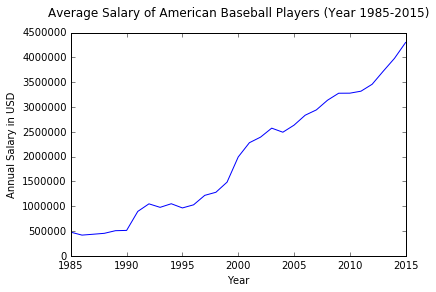

In [14]:
salary=pd.read_csv(csv_path('Salaries.csv'))
plt.plot(salary.groupby(['yearID'])['salary'].mean())
plt.title('Average Salary of American Baseball Players (Year 1985-2015)' ).set_position([.5, 1.05])
plt.xlabel('Year')
plt.ylabel('Annual Salary in USD')

To narrow down the scope, let's focus on the salary data of the most recent year, that is year 2015.

In [15]:
salary_2015=salary[salary['yearID']==2015]
print(len(salary_2015))
salary_2015.head()

817


,yearID,teamID,lgID,playerID,salary
24758,2015,ARI,NL,ahmedni01,508500
24759,2015,ARI,NL,anderch01,512500
24760,2015,ARI,NL,chafian01,507500
24761,2015,ARI,NL,collmjo01,1400000
24762,2015,ARI,NL,corbipa01,524000


On average, players have 6-figure annual salary, but the variance is very high:

In [16]:
salary_2015['salary'].describe()

count    8.170000e+02
mean     4.301276e+06
std      5.506178e+06
min      5.070000e+05
25%      5.225000e+05
50%      1.880000e+06
75%      5.875000e+06
max      3.257100e+07
Name: salary, dtype: float64

With bin size of 1 million, we can observe an obvious positive skew in the salary distribution histogram. The long tail indicates a few star players enjoy extremely high salary.

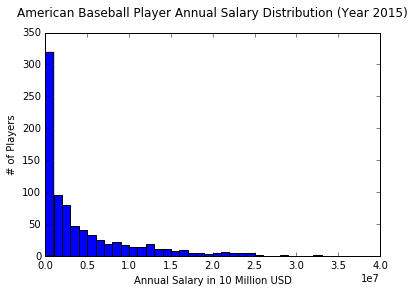

In [29]:
plt.hist(salary_2015['salary'],bins=40,range=(0,4*(10**7)))
plt.title('American Baseball Player Annual Salary Distribution (Year 2015)').set_position([.5, 1.05])
plt.xlabel('Annual Salary in 10 Million USD')
plt.ylabel('# of Players')

### 3.1 Salary vs League

The salary distribution patthern is similar for two leagues(AL and NL). Playing for which league doesn't seem to be a significant influence factor on salary level.

In [18]:
grouped_salary=salary_2015.groupby(['lgID'])
grouped_salary['salary'].describe()

lgID       
AL    count    4.150000e+02
      mean     4.387325e+06
      std      5.642554e+06
      min      5.070000e+05
      25%      5.217000e+05
      50%      1.850000e+06
      75%      5.937500e+06
      max      2.800000e+07
NL    count    4.020000e+02
      mean     4.212445e+06
      std      5.367338e+06
      min      5.075000e+05
      25%      5.239438e+05
      50%      1.912500e+06
      75%      5.806250e+06
      max      3.257100e+07
Name: salary, dtype: float64

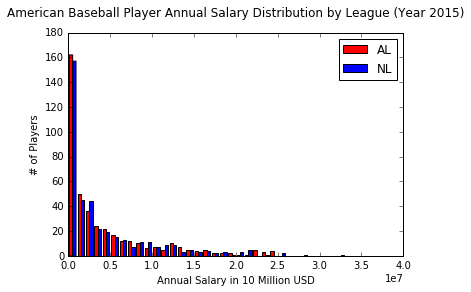

In [30]:
#Distribution of all data
plt.hist([salary_2015.loc[grouped_salary.groups['AL']]['salary'],salary_2015.loc[grouped_salary.groups['NL']]['salary']],bins=40,range=(0,4*(10**7)),color=['red','blue'], label=['AL','NL'])
plt.title('American Baseball Player Annual Salary Distribution by League (Year 2015)').set_position([.5, 1.05])
plt.xlabel('Annual Salary in 10 Million USD')
plt.ylabel('# of Players')
plt.legend()

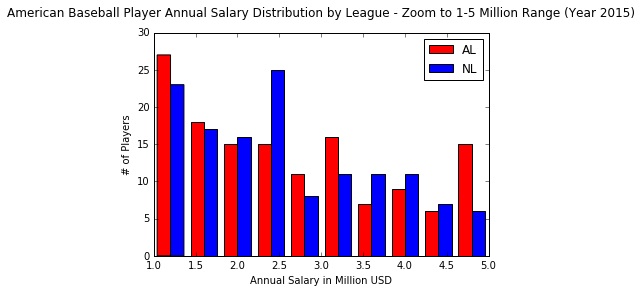

In [22]:
#Zoom to 1-5 millions
plt.hist([salary_2015.loc[grouped_salary.groups['AL']]['salary']/1000000,salary_2015.loc[grouped_salary.groups['NL']]['salary']/1000000],bins=10,range=(1,5),color=['red','blue'], label=['AL','NL'])
plt.title('American Baseball Player Annual Salary Distribution by League - Zoom to 1-5 Million Range (Year 2015)').set_position([.5, 1.05])
plt.xlabel('Annual Salary in Million USD')
plt.ylabel('# of Players')
plt.legend()

### 3.2 Salary vs Player's Experience

#### 3.2.1 Salary vs Total Years Played:
One reasonable assumption is: The longer a player played in the league, the higher the annual salary. So we can run a linear regression between those two variables.

In [23]:
# Mapping yearsPlayed from Master table to salary table
bio_salary_2015=master_selected[['playerID','yearsPlayed']].merge(salary_2015,how='inner',left_on='playerID',right_on='playerID')
print(len(bio_salary_2015))
bio_salary_2015.head()

754


,playerID,yearsPlayed,yearID,teamID,lgID,salary
0,abadfe01,5.19,2015,OAK,AL,1087500
1,abreujo02,1.51,2015,CHA,AL,8666000
2,ackledu01,4.30,2015,SEA,AL,2600000
3,adamsau01,1.22,2015,CLE,AL,507700
4,adamsma01,3.38,2015,SLN,NL,534000


In [25]:
#Create a single linear regression function for repeat use
def single_lin(df, x_col,y_col):
    ind=df[x_col]
    dep=df[y_col]
    slope, intercept, r_value, p_value, std_err = stats.linregress(ind,dep)
    print('p vulue is {}, r is {}'.format(p_value,round(r_value,3)))
    print('Regression line is: y={}+x*{}'.format(round(intercept,2),round(slope,2)))
    plt.scatter(ind,dep)
    plt.plot(ind,ind*slope+intercept,color='red')

The result is aligned with early assumption: r = 0.63 indicates a positive linear relation between player's experience and salary:

p vulue is 6.37081249073996e-86, r is 0.634
Regression line is: y=-1833173.25+x*1101814.98


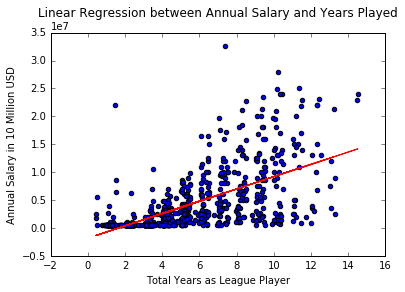

In [28]:
single_lin(bio_salary_2015,'yearsPlayed','salary')
plt.title('Linear Regression between Annual Salary and Years Played').set_position([.5, 1.05])
plt.ylabel('Annual Salary in 10 Million USD')
plt.xlabel('Total Years as League Player')

#### 3.2.2 Salary vs Total Awards Earned:
Another assumption is that the more awards a player earned throughout his career, the higher the annual salary. 

In [27]:
# Import award information and count how many awards each player earned throughout career history
awards=pd.read_csv(csv_path('AwardsPlayers.csv'))
award_count=pd.DataFrame({'award':awards.groupby(['playerID'])['awardID'].count()})
bio_salary_2015=bio_salary_2015.merge(award_count,how='left',left_on='playerID',right_index=True).fillna(0)
bio_salary_2015.head()

,playerID,yearsPlayed,yearID,teamID,lgID,salary,award
0,abadfe01,5.19,2015,OAK,AL,1087500,0.0
1,abreujo02,1.51,2015,CHA,AL,8666000,2.0
2,ackledu01,4.30,2015,SEA,AL,2600000,0.0
3,adamsau01,1.22,2015,CLE,AL,507700,0.0
4,adamsma01,3.38,2015,SLN,NL,534000,0.0


r of 0.60 indicates a relatively strong positive linear relation between salary and award:

p vulue is 6.114640576382312e-74, r is 0.597
Regression line is: y=3021985.55+x*1862598.24


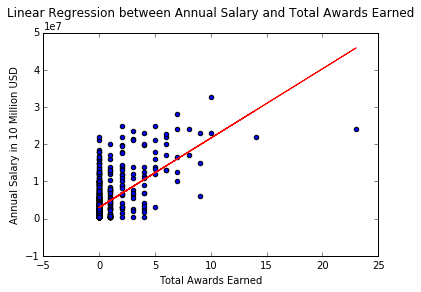

In [42]:
single_lin(bio_salary_2015,'award','salary')
plt.title('Linear Regression between Annual Salary and Total Awards Earned').set_position([.5, 1.05])
plt.ylabel('Annual Salary in 10 Million USD')
plt.xlabel('Total Awards Earned')

#### 3.2.3 Multiple Linear Regression:
However, more experienced players are more likely to earn more awards in career history, so we better run a multiple linear regression with both yearsPlayed and award.

The result below indicates that both award and yearsPlayed are positively related with salary. It is unlikely that yearsPlayed is the lurking variable behind award and salary's correlation.

In [31]:
model = ols('salary~yearsPlayed+award',data=bio_salary_2015).fit()
print(model.summary())  

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     471.7
Date:                Sat, 21 Jan 2017   Prob (F-statistic):          2.03e-133
Time:                        16:50:41   Log-Likelihood:                -12449.
No. Observations:                 754   AIC:                         2.490e+04
Df Residuals:                     751   BIC:                         2.492e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept   -1.141e+06   2.64e+05     -4.318      

### 3.3 Salary vs Player's Appearances

In [32]:
# Import appearance information of each individual player and focus on rows of year 2015 only
appear=pd.read_csv(csv_path('Appearances.csv'))
appear_2015=appear.copy()[appear['yearID']==2015]

# I observed some missing values among 'G_*' columns. 
# Since I will only use those columns to identify the major role of each player, I am going to fill those missing values with 0
appear_2015=appear_2015.fillna(0)
appear_2015.head()

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
99466,2015,ATL,NL,aardsda01,33.0,0.0,30,33.0,33,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
99467,2015,OAK,AL,abadfe01,62.0,0.0,4,62.0,62,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
99468,2015,CHA,AL,abreujo02,154.0,154.0,154,115.0,0,0,...,0,0,0,0,0,0,0,39.0,0.0,0.0
99469,2015,MIN,AL,achteaj01,11.0,0.0,1,11.0,11,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
99470,2015,NYA,AL,ackledu01,23.0,14.0,23,17.0,0,0,...,9,0,0,4,0,0,4,2.0,9.0,0.0


Seems each player can play different roles in different games. For the convenience of later categorization, I gonna tag each player with one single role, by finding out the most frequently played role within year 2015.

In [33]:
# Tag each player with one main role in the games
positions=appear.columns[8:]
def main_role(row):
    row['main_role']=row[positions].argmax()
    return row

appear_2015=appear_2015.apply(main_role,axis=1)
appear_2015.head()

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,main_role
99466,2015,ATL,NL,aardsda01,33.0,0.0,30,33.0,33,0,...,0,0,0,0,0,0,0.0,0.0,0.0,G_p
99467,2015,OAK,AL,abadfe01,62.0,0.0,4,62.0,62,0,...,0,0,0,0,0,0,0.0,0.0,0.0,G_p
99468,2015,CHA,AL,abreujo02,154.0,154.0,154,115.0,0,0,...,0,0,0,0,0,0,39.0,0.0,0.0,G_1b
99469,2015,MIN,AL,achteaj01,11.0,0.0,1,11.0,11,0,...,0,0,0,0,0,0,0.0,0.0,0.0,G_p
99470,2015,NYA,AL,ackledu01,23.0,14.0,23,17.0,0,0,...,0,0,4,0,0,4,2.0,9.0,0.0,G_2b


I will explore two variables' relation with salary separately:
- Each player's total games played in year 2015
- Player's main role in the game

So I mapped those two variable with salary data for later use:

In [34]:
appear_salary_2015=salary_2015.merge(appear_2015[['playerID','G_all','main_role']],how='inner',left_on='playerID',right_on='playerID')
appear_salary_2015.head()

,yearID,teamID,lgID,playerID,salary,G_all,main_role
0,2015,ARI,NL,ahmedni01,508500,134.0,G_ss
1,2015,ARI,NL,anderch01,512500,28.0,G_p
2,2015,ARI,NL,chafian01,507500,66.0,G_p
3,2015,ARI,NL,collmjo01,1400000,44.0,G_p
4,2015,ARI,NL,corbipa01,524000,16.0,G_p


#### 3.3.1 Salary vs Total Games Played:
I assume the more games the player played in a year, the higher the salary. There is a positive linear relationship between those two variables, but r is only 0.15, the relation is weak.

p vulue is 6.326632180180889e-06, r is 0.149
Regression line is: y=3323539.49+x*17300.2


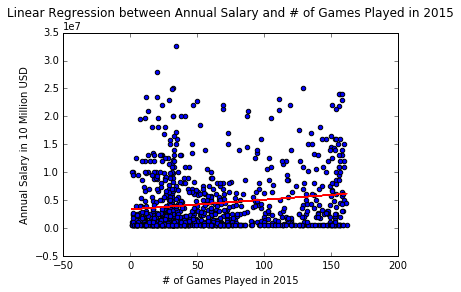

In [35]:
single_lin(appear_salary_2015,'G_all','salary')
plt.title('Linear Regression between Annual Salary and # of Games Played in 2015').set_position([.5, 1.05])
plt.ylabel('Annual Salary in 10 Million USD')
plt.xlabel('# of Games Played in 2015')

#### 3.3.2 Salary vs Player's Role:
Plotting boxplot by player's main role, some preliminary findings can be observed:
- On average, three types of fielders(G_lf: leftfielders; G_rf: rightfielders; G_cf: centerfielders) usually earn higher salary
- The average salary of pitchers(G_p) and outfielders(G_of) are low, but there are many outliers in those two categories, meaning exceptional pitchers and outfielders can enjoy a high salary level compared with all types of baseball players
- Pinch hitter(G_ph) seems like an unimportant role,both the mean and the variance of pinch hitters are low

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


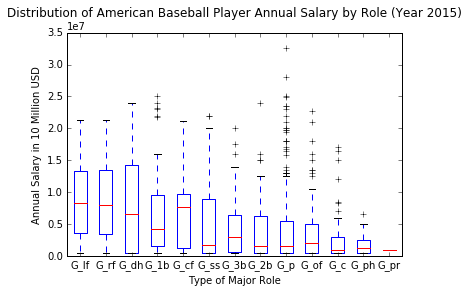

In [36]:
#Create a function to plot separate boxplot for each type of role within one chart
def create_boxplot(df,group_key,target_data):
    grouped=df.groupby([group_key])
    category=grouped[target_data].mean()
    category.sort(ascending=False)
    plot_data=[]
    xticks=[]
    for i in range(len(category)):
        cat_data=df.loc[grouped.groups[category.index[i]]][target_data]
        plot_data.append(cat_data)
        xticks.append(category.index[i])
    plt.boxplot(plot_data)
    plt.xticks(np.arange(len(category))+1,xticks)
    
create_boxplot(appear_salary_2015,'main_role','salary')
plt.title('Distribution of American Baseball Player Annual Salary by Role (Year 2015)').set_position([.5, 1.05])
plt.ylabel('Annual Salary in 10 Million USD')
plt.xlabel('Type of Major Role')

## Part 4: Summary of Key Findings

#### Key Findings in Player's Biography:
- Most American Baseball Players started their career in professional leagues at age 23-26. While some young talents can enter league before age 20, players who debut after age 30 also exist.
- Although some players can stay in the league for more than 10 years, in general the league career length is short. On average, players only stay in the league for ~3 years. Some players even played just one game in the league and then quit immediately.  
- AL and NL do attract talented players around the world, 28% of inspected players were born outside America.
- A player's batting hand and throwing hand are not necessarily the same, 14% players' batting hand is the opposite of throwing hands

**The findings above were based on player pool of 1980-2015, the full database includes data since 1820. If I expand my time frame,or choose a different subset, the patterns might change. It would be interesting if I compare those stats between different time frame in further analysis.** 

#### Key Findings in Salary Analysis:
- For the past three decades, the salary of American baseball players grew steadily in general. It might result from macro-economic growth, inflation, as well as improvement of social status of sport professionals. The true reasons behind this observed growth trend may require further analysis.  
- The distribution of salary level represents a typical long-tail pattern: while most players earn a 6-figure annual salary, the most outstanding ones enjoy a 7-figure income.
- There is no signifant difference of salary distribution between AL and NL, which is not surprising, since two leagues are almost equally famous and professional.
- A relatively strong linear correlation is observed between salary level and total years played in the league. More experienced players tend to earn higher salary. On top of that, total awards earned in the past is also positively correlated with salary level, since besides experience, award is an extra proof of player's talent.
- The correlation between salary and # of games played within a year is weak. The assumption that more talented players are likely to earn higher salary and they also tend to join more games requires further inspection.
- Salary level does vary for different types of role: Leftfielders, rightfielders and centerfielders usually earn higher salary. While the average salary of pitchers and outfielders are low, there are many outliers in those two categories, meaning exceptional pitchers and outfielders can enjoy a high salary level compared with all types of baseball players.

**The salary analysis only inspected salary level of year 2015, observed correlations might be corroborated or weakened by analysis of other years.** 

## Part 5: Limitations of This Analysis

This is really just a preliminary analysis on a small piece of the original baseball database.

Major limitations of this analysis can be summarized below:
1. Overly simplified inspection:
    - For relation between different variables, I only inspected on linear relation, and mainly on single variable regression
    - Many variables provided in the database are not adopted
2. My knowledge of inferential statistics is limited, so the interpretation of regression result is superficial

3. I have very little background knowledge about baseball games, so my assumptions about the data is not very insightful